# Modeling CPI - Exploratory Data Analysis
****


 Modelling inflation has been one of the most difficult challenges for econometricians in the meaning of quantitative analysis throughout the past years. Due to its volatile nature, unclear dependencies - also multivariate - nonlinearities, sometimes long memory and time-varying covariates. 
 
 Why CPI out of so many other series? Well, recently the big wave of inflation has influenced everybody's life and even though I assess the chances of success as rather low, I think it's going to be a good way to try out my skills, find out something more on the way and maybe discover a new economic dependency.

In this experiment, I'm going to take up this challenge and try to find a model that would explain the underlying process starting with univariate time series analysis. Let's start with importing and plotting the data:

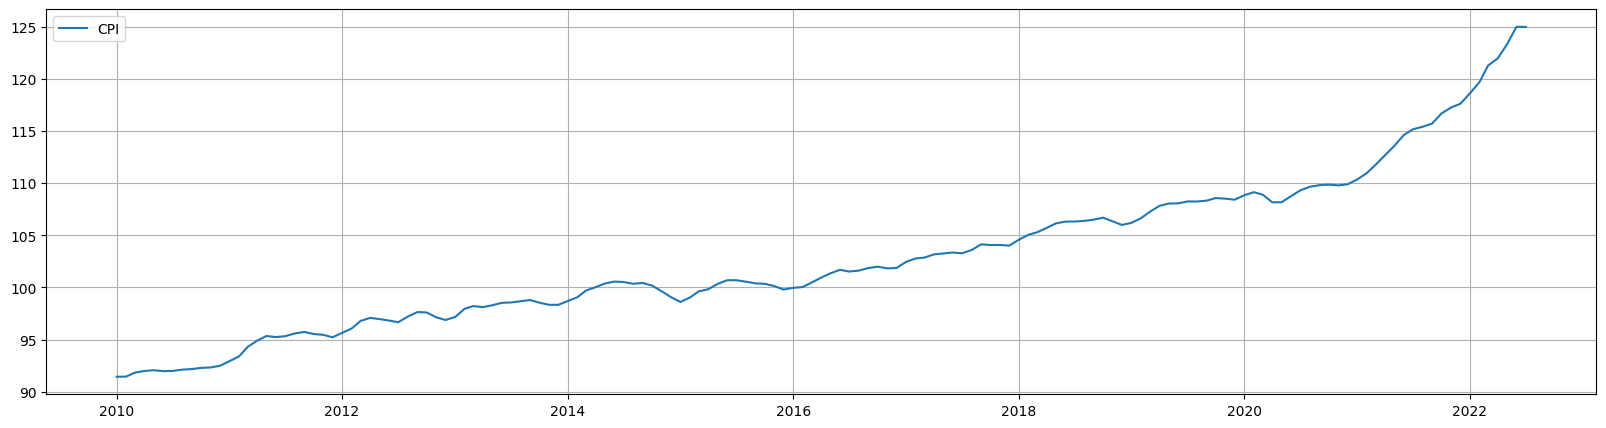

In [3]:
start = "2010-01-01"
data = FRED().get("USACPIALLMINMEI", observation_start=start)
data = pd.DataFrame({"CPI": data.values}, index=data.index)

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(data, label="CPI")
plt.legend()
plt.show()

#### Ugh this does not look good - not only for our wallets (since CPI of the US is usually correlated/cointegrated with other countries) but also it seems like we can forget about easy stationarity.  

Moreover, there is an apparent structural change at the end, after 2020. At first I'm going to ignore it and try to model it altogether, in some further analysis I'm going to try separating it. Why not to do it in the first place? The shock has happened quite recently and simple ARIMA models do not hold well when there is less than ~50 time points. Going even further, it's possible that maximum likelihood estimation as well as least squares in that case will not hold neither due to for example outliers. There are certain methods to deal with that, but it will not be as beautiful as using simple pre-made models.
 
 
 Let's put it through a logarithm and subtract it:

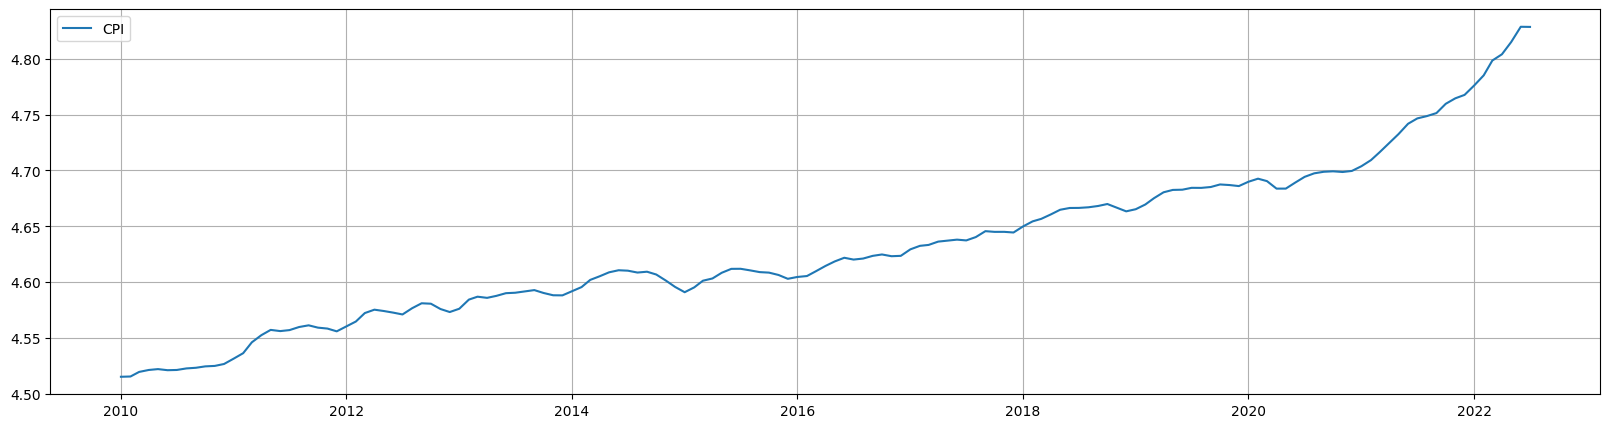

In [4]:
data = np.log(data)
diff = data.diff(1)[1:]

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(data, label="CPI")
plt.legend()
plt.show()

***
Logged values don't look much better but it won't hurt to use them for their normality features. Let's see the distribution of the differences first:
***

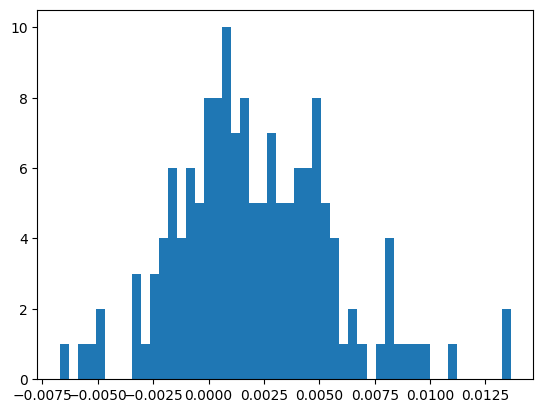

      Mean      Median    St. Dev.      Skew    Kurtosis    Durbin-Watson    JB-stat    JB-pvalue
----------  ----------  ----------  --------  ----------  ---------------  ---------  -----------
0.00208558  0.00172617  0.00352661  0.458536     3.76709          0.63004    8.23168    0.0163122


In [75]:
functs.functs.descriptive(diff, bins=3)


Depending on how we interpret it, the distribution here can be either normal or bimodal - since there seems to be a second mode around 0.005. Jarque-Bera test also rejects the null hypothesis of normality of the distribution. I'm going to assume the distribution is therefore not normal, but its empirical shape does not concern me up to a degree to stop the analysis right away. First indication of a possible nonlinear relationships? Let's check the stationarity of the series and its differences:


In [5]:
%R -i diff
%R -i data

In [9]:
%%R

adf.test(as.ts(data))
kpss.test(as.ts(data))
print("---------------------- diff ---------------------------")
adf.test(as.ts(diff))
kpss.test(as.ts(diff))

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag  ADF p.value
[1,]   0 7.32    0.99
[2,]   1 3.25    0.99
[3,]   2 3.74    0.99
[4,]   3 3.34    0.99
[5,]   4 3.06    0.99
Type 2: with drift no trend 
     lag  ADF p.value
[1,]   0 4.18    0.99
[2,]   1 1.58    0.99
[3,]   2 2.32    0.99
[4,]   3 2.05    0.99
[5,]   4 1.96    0.99
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 3.3917    0.99
[2,]   1 0.0096    0.99
[3,]   2 1.0314    0.99
[4,]   3 0.8148    0.99
[5,]   4 0.7395    0.99
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 
KPSS Unit Root Test 
alternative: nonstationary 
 
Type 1: no drift no trend 
 lag  stat p.value
   2 0.728     0.1
----- 
 Type 2: with drift no trend 
 lag  stat p.value
   2 0.245     0.1
----- 
 Type 1: with drift and trend 
 lag  stat p.value
   2 0.116     0.1
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 
[1] "-----------------


Wow! Despite the obvious structural break between 2020 and 2021 the first differences are stationary according to both ADF and KPSS tests. Let's confirm it additionally with Phillip-Perron test, but keep in mind that the probe is quite small which means that it does not hold its normal power:


In [91]:
%%R
pp.test(as.vector(diff$CPI))


	Phillips-Perron Unit Root Test

data:  as.vector(diff$CPI)
Dickey-Fuller Z(alpha) = -63.362, Truncation lag parameter = 4, p-value
= 0.01
alternative hypothesis: stationary



PP test also rejects $H_0$ about nonstationarity. But hold on! The first differences might indeed be stationary, but what if the original series exhibits medium or long memory? We would suffer from serious information loss! Let's check it out:

In [79]:
%%R

fracdiff::fdGPH(data)

$d
[1] 0.9586711

$sd.as
[1] 0.1141551

$sd.reg
[1] 0.03478532



The $d$ parameter is nowhere between -0.5 and 0.5, which means that there is no long nor medium memory. That's a shame, but let's continue with the first differences. I'm going to start with the simplest linear autocorrelation plots:

C:\Users\micuk\AppData\Local\Temp\ipykernel_185612\3325617868.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  sm.graphics.tsa.plot_acf(diff).show()
C:\Users\micuk\AppData\Local\Temp\ipykernel_185612\3325617868.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  sm.graphics.tsa.plot_pacf(diff).show()


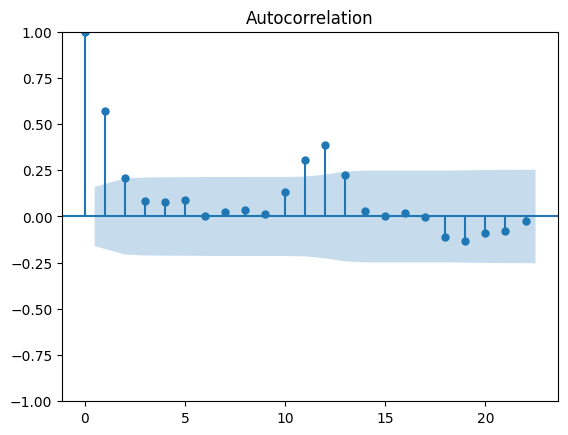

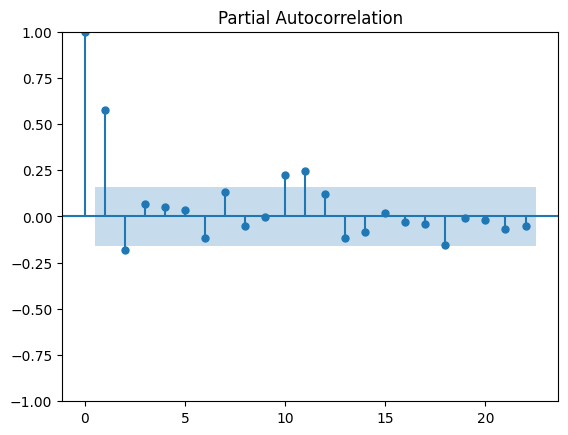

In [13]:
sm.graphics.tsa.plot_acf(diff).show()
sm.graphics.tsa.plot_pacf(diff).show()

Both acf and pacf show statistically significant autocorrelations. Great! It means that we might be able to use some sort of autoregressive model later on. But wait, see these (p)acf correlations at 11th and 12th lag...? Does it not look like... seasonality? It's about time for seasonplots!

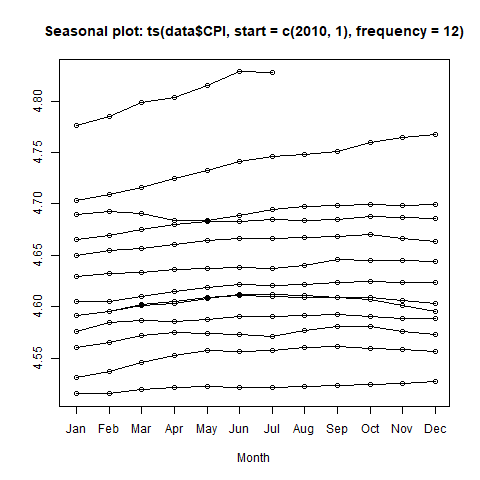

In [95]:
%%R
options(repr.plot.width=8, repr.plot.height=3)
{seasonplot(ts(data$CPI, start=c(2010,01), frequency=12))
abline(h=0, col='red')}

I'm not sure how about you, but I can't see much of a pattern here. Let's try out the differences:

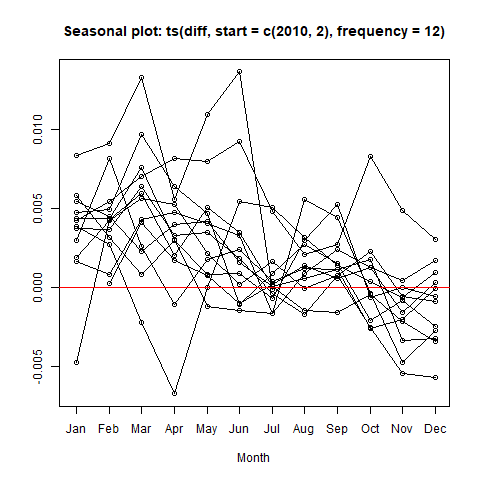

In [94]:
%%R
options(repr.plot.width=8, repr.plot.height=3)
{seasonplot(ts(diff, start=c(2010,02), frequency=12))
abline(h=0, col='red')}

That looks like it's more clear. The seasonality here does not look unequivocal, but it does seem like there is a pattern here. Existance of seasonality indicates there might be nonlinearity in the data - since you can define any deviance from infinite autoregressive process as nonlinearity - but it does not prove for now that some sort of NARMA model will be needed. For now let us take a look at the lagplots:

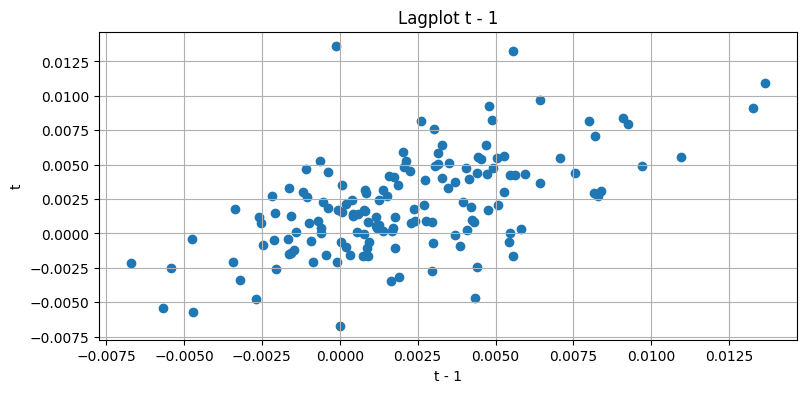

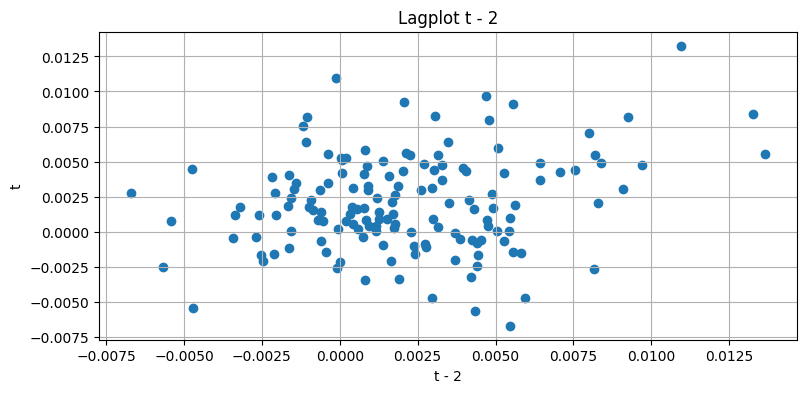

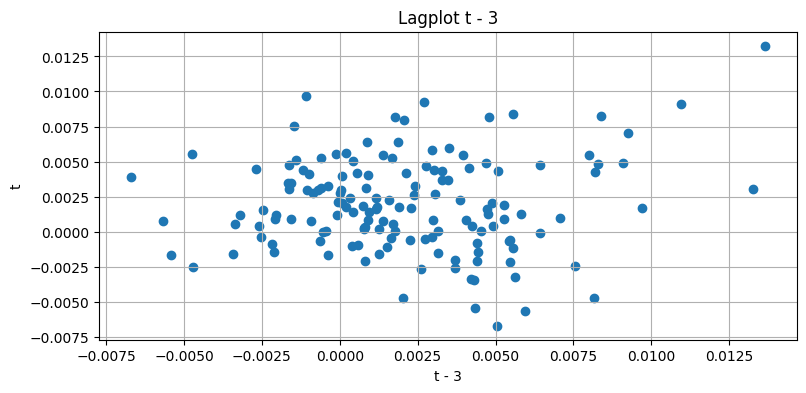

In [10]:
functs.functs.lag_plot(diff, 3)

Alright, this definitely does look like some kind of nonlinear relationship, especially in lags 2 and 3. It's also another hint for checking out nonlinear models, but **it's imperative to remember that linear models very often outperform nonlinear ones since all of them minimise $MSE$**. We will thus check all of them. 

At first I'm going to gridsearch SARIMA models using both AIC and BIC:

In [17]:
import pmdarima

sarima_aic = pmdarima.auto_arima(data, start_p=1, start_q=1, max_p=5, max_q=5, max_d=1, seasonal=True, trace=True, m=12, information_criterion="aic", stationary=False, max_P=4, max_D=1, max_Q=4,)
sarima_bic = pmdarima.auto_arima(data, start_p=1, start_q=1, max_p=5, max_q=5, max_d=1, seasonal=True, trace=True, m=12, information_criterion="bic", stationary=False, max_P=4, max_D=1, max_Q=4,)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-1339.011, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1265.548, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1325.322, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1332.021, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1222.300, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-1336.921, Time=0.24 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-1322.282, Time=0.18 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=-1333.446, Time=0.61 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=-1344.502, Time=0.93 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=-1342.045, Time=0.64 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=-1304.037, Time=0.77 sec
 ARIMA(1,1,1)(1,0,3)[12] intercept   : AIC=-1336.865, Time=3.18 sec
 ARIMA(1,1,1)(0,0,3)[12] intercept   : AIC=-1340.347, Time=1.88 sec
 ARIMA(1,1,1)(2,0,3)[12] intercept   : AIC=-1336.588, Time=2.22 sec
 ARIM

In [19]:
print(sarima_aic.summary())
print(sarima_bic.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  151
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 679.251
Date:                                 Mon, 10 Oct 2022   AIC                          -1344.502
Time:                                         17:31:47   BIC                          -1323.428
Sample:                                              0   HQIC                         -1335.941
                                                 - 151                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.044      0.297      -0.000       0

-----------------------------AIC----------------------------------


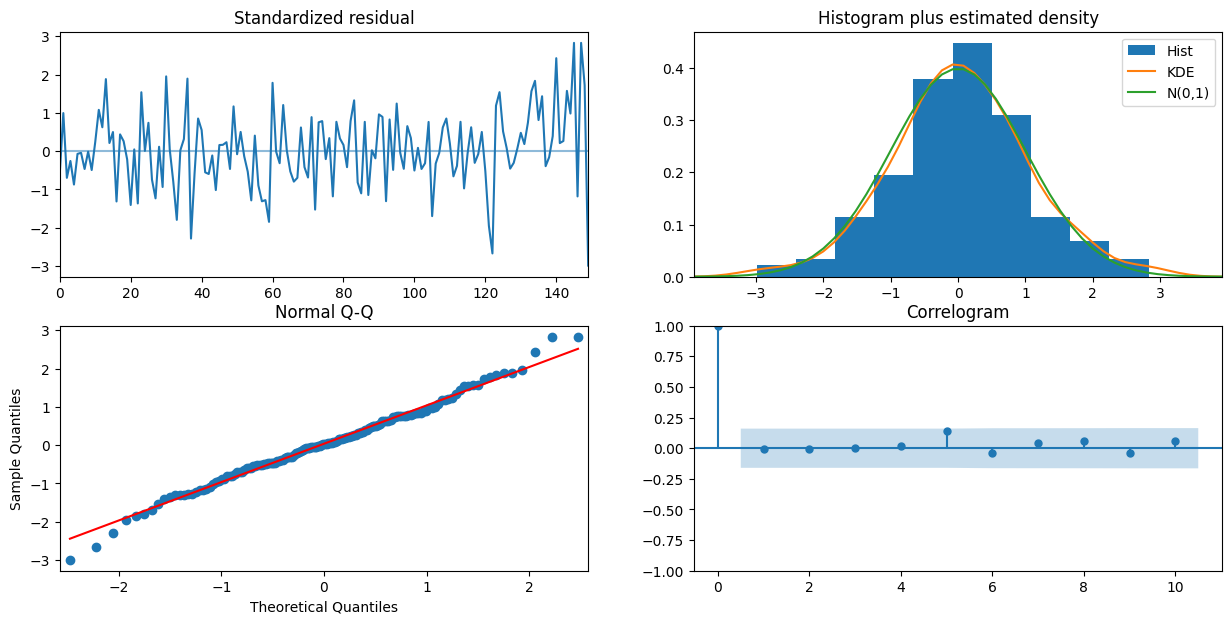

-----------------------------BIC----------------------------------


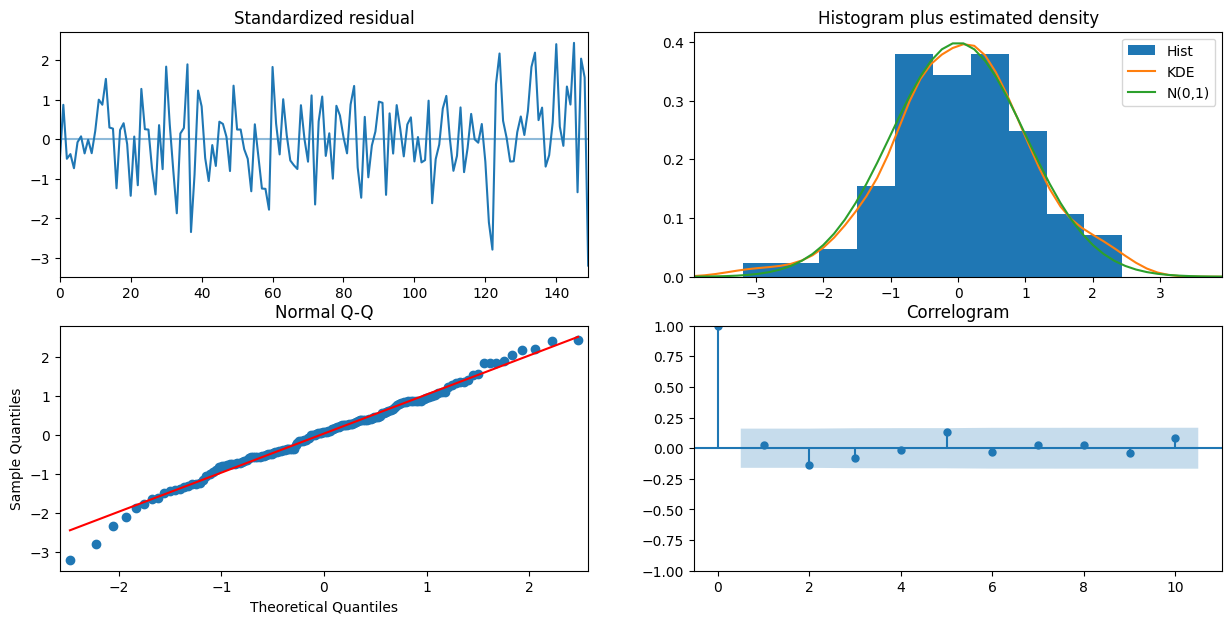

In [60]:
print("-----------------------------AIC----------------------------------")
sarima_aic.plot_diagnostics(figsize=(15,7))
plt.show()
print("-----------------------------BIC----------------------------------")
sarima_bic.plot_diagnostics(figsize=(15,7))
plt.show()

Alright, the results look actually quite promising! Boths models' residuals seem to have normal distribution and not to be autocorrelated. Then come the standarized residuals over time - they do not seem to be *really* dependent on time, but it's important to notice, that there are several places in which their shape looks persistent. Less in the case of the model generated by BIC.

Such diagnosis is insuficcient however and I will go deeper down into details. Let's first check the residuals' stationarity:

In [103]:
resids_aic = sarima_aic.resid()
resids_bic = sarima_bic.resid()

In [104]:
%R -i resids_aic
%R -i resids_bic

In [113]:
%%R
print(adf.test(as.vector(resids_aic[1:length(resids_aic)])))
print(adf.test(as.vector(resids_bic[1:length(resids_aic)])))

print(kpss.test(as.vector(resids_aic[1:length(resids_aic)])))
print(kpss.test(as.vector(resids_bic[1:length(resids_aic)])))


	Augmented Dickey-Fuller Test

data:  as.vector(resids_aic[1:length(resids_aic)])
Dickey-Fuller = -4.7999, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


	Augmented Dickey-Fuller Test

data:  as.vector(resids_bic[1:length(resids_aic)])
Dickey-Fuller = -5.4559, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


	KPSS Test for Level Stationarity

data:  as.vector(resids_aic[1:length(resids_aic)])
KPSS Level = 0.32923, Truncation lag parameter = 4, p-value = 0.1


	KPSS Test for Level Stationarity

data:  as.vector(resids_bic[1:length(resids_aic)])
KPSS Level = 0.32991, Truncation lag parameter = 4, p-value = 0.1



Alright, **the residuals are confirmed to be stationary**. This is really good! There is only one extremely important thing to check, but seeing how wonderfully everything has gone so far I'm entirely sure it will go alright. The remaining feature to be checked is obviously the conditional heteroskedasticity - so called ARCH effect. Let's start with some simple acf/pacf test for squared residuals:

C:\Users\micuk\AppData\Local\Temp\ipykernel_185612\2439686678.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  sm.graphics.tsa.plot_acf(resids_aic[1:]**2).show()
C:\Users\micuk\AppData\Local\Temp\ipykernel_185612\2439686678.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  sm.graphics.tsa.plot_pacf(resids_aic[1:]**2).show()
C:\Users\micuk\AppData\Local\Temp\ipykernel_185612\2439686678.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  sm.graphics.tsa.plot_acf(resids_bic[1:]**2).show()
C:\Users\micuk\AppData\Local\Temp\ipykernel_185612\2439686678.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  sm

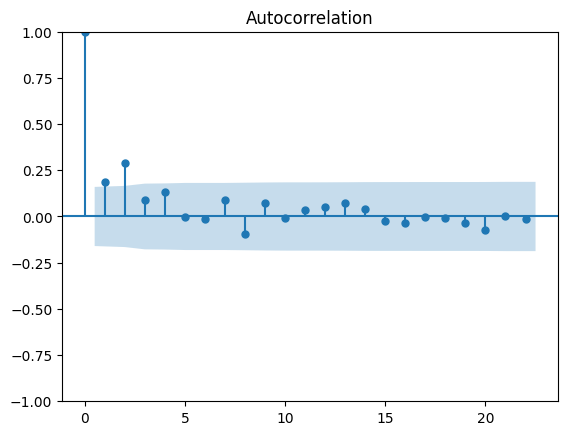

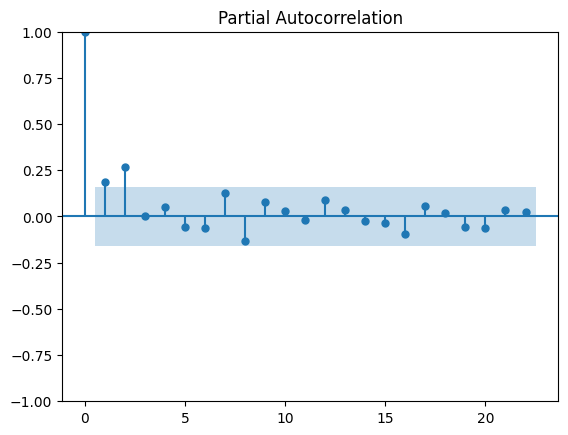

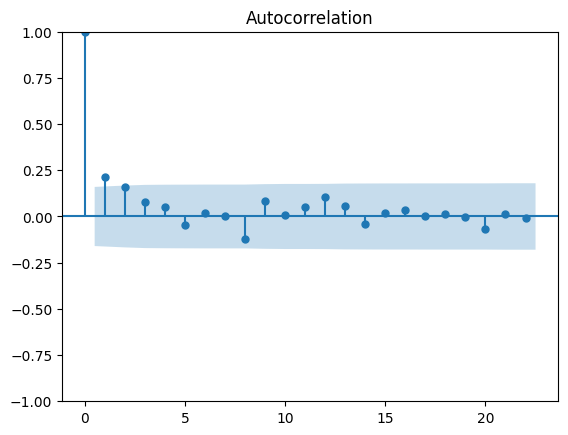

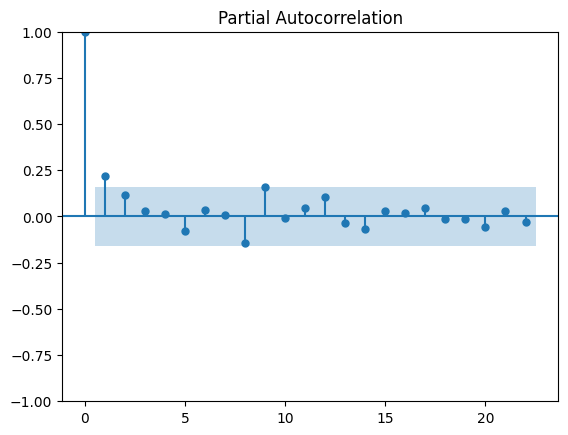

In [115]:
sm.graphics.tsa.plot_acf(resids_aic[1:]**2).show()
sm.graphics.tsa.plot_pacf(resids_aic[1:]**2).show()

sm.graphics.tsa.plot_acf(resids_bic[1:]**2).show()
sm.graphics.tsa.plot_pacf(resids_bic[1:]**2).show()

***Things were going way too well, were they not?*** Our model exhibits conditional heteroskedasticity! Let us be hopeful it's not true though and let's confirm it with a formal test:

In [120]:
%%R

print(Box.test(resids_aic[2:length(resids_aic)]^2, type="Ljung"))
print(Box.test(resids_bic[2:length(resids_bic)]^2, type="Ljung"))


	Box-Ljung test

data:  resids_aic[2:length(resids_aic)]^2
X-squared = 5.33, df = 1, p-value = 0.02096


	Box-Ljung test

data:  resids_bic[2:length(resids_bic)]^2
X-squared = 7.0777, df = 1, p-value = 0.007805



The Ljung-Box tests in both cases have rejected the null hypothesis about lack of autocorrelation of squared residuals, **both models exhibit conditional heteroskedasticity**. Let's take a look at the overall fit:

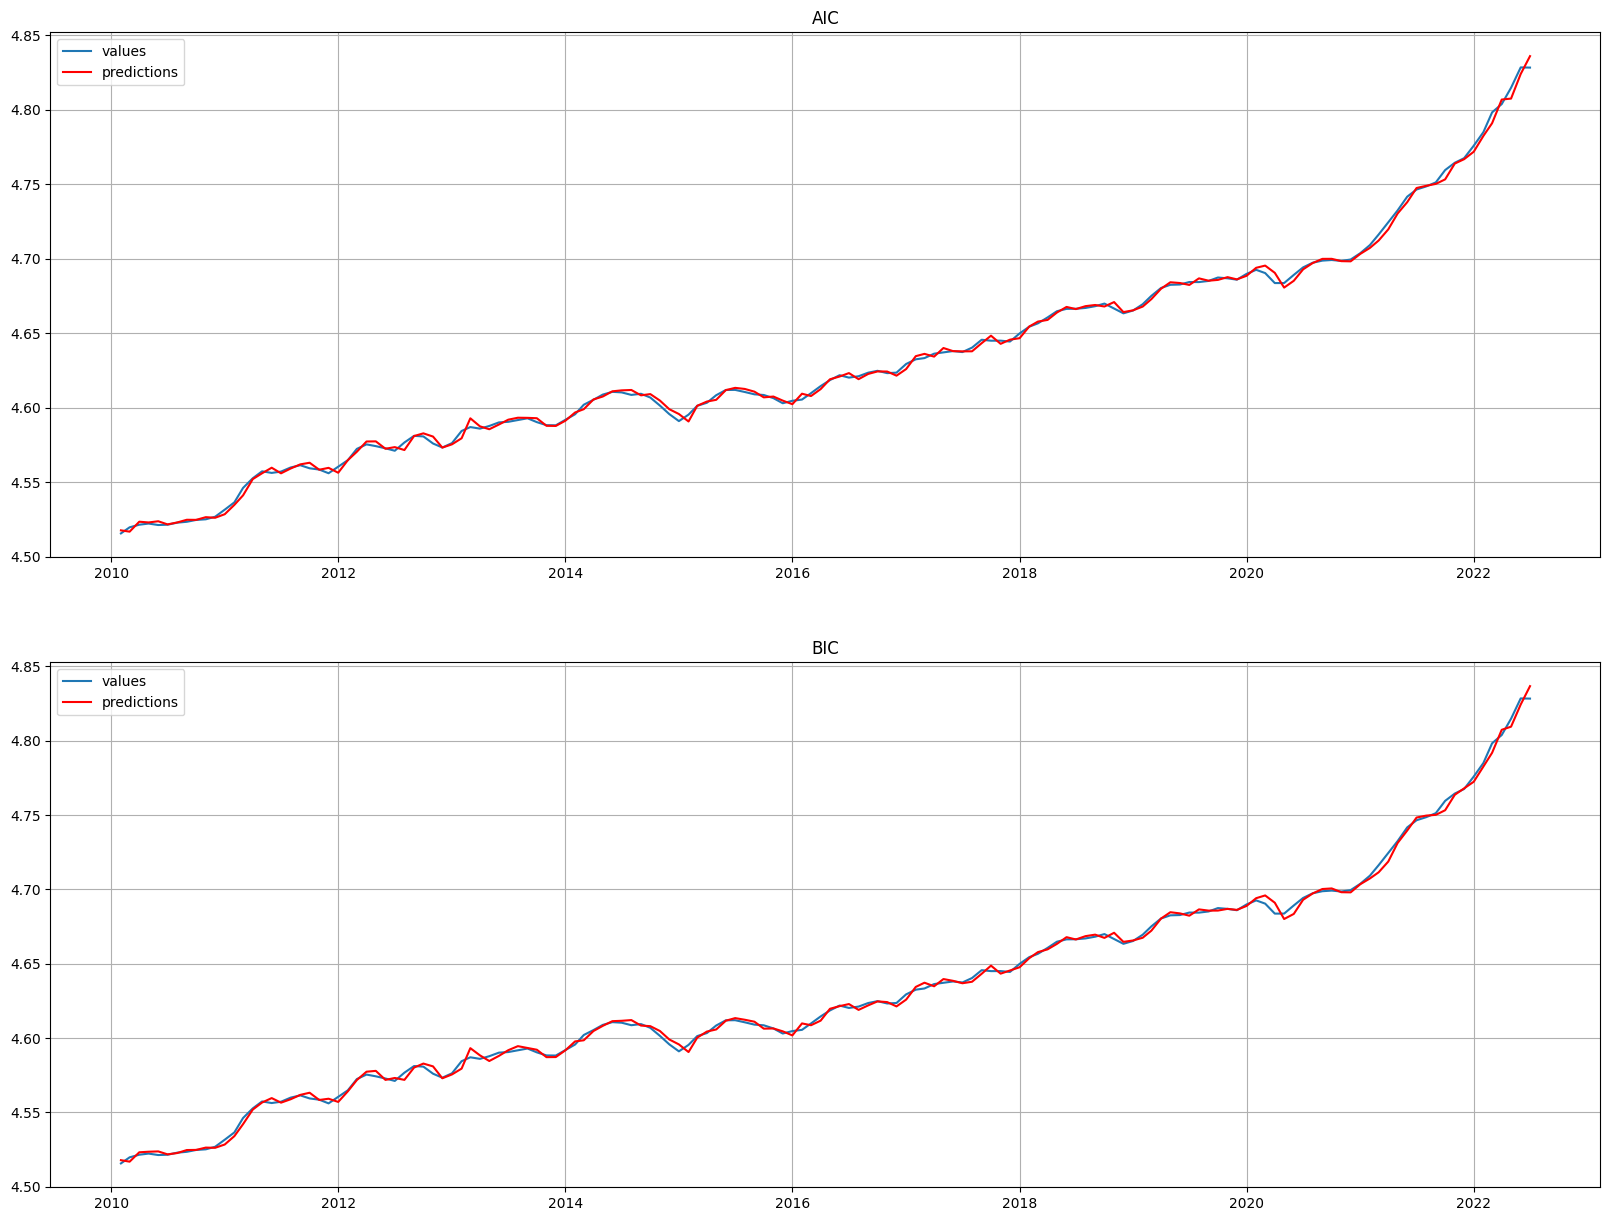

In [129]:
fig, ax = plt.subplots(2,1, figsize=(20,15))

ax[0].plot((data[1:]), label='values')
ax[0].plot((data[1:] - pd.DataFrame(resids_aic[1:], index=data.index[1:], columns=data.columns)), c='r', label='predictions')
ax[0].grid()
ax[0].legend()
ax[0].title.set_text("AIC")

ax[1].plot(data[1:], label='values')
ax[1].plot(data[1:] - pd.DataFrame(resids_bic[1:], index=data.index[1:], columns=data.columns), c='r', label='predictions')
ax[1].grid()
ax[1].legend()
ax[1].title.set_text("BIC")

plt.show()

I can't see anything here. Let's zoom it a bit:

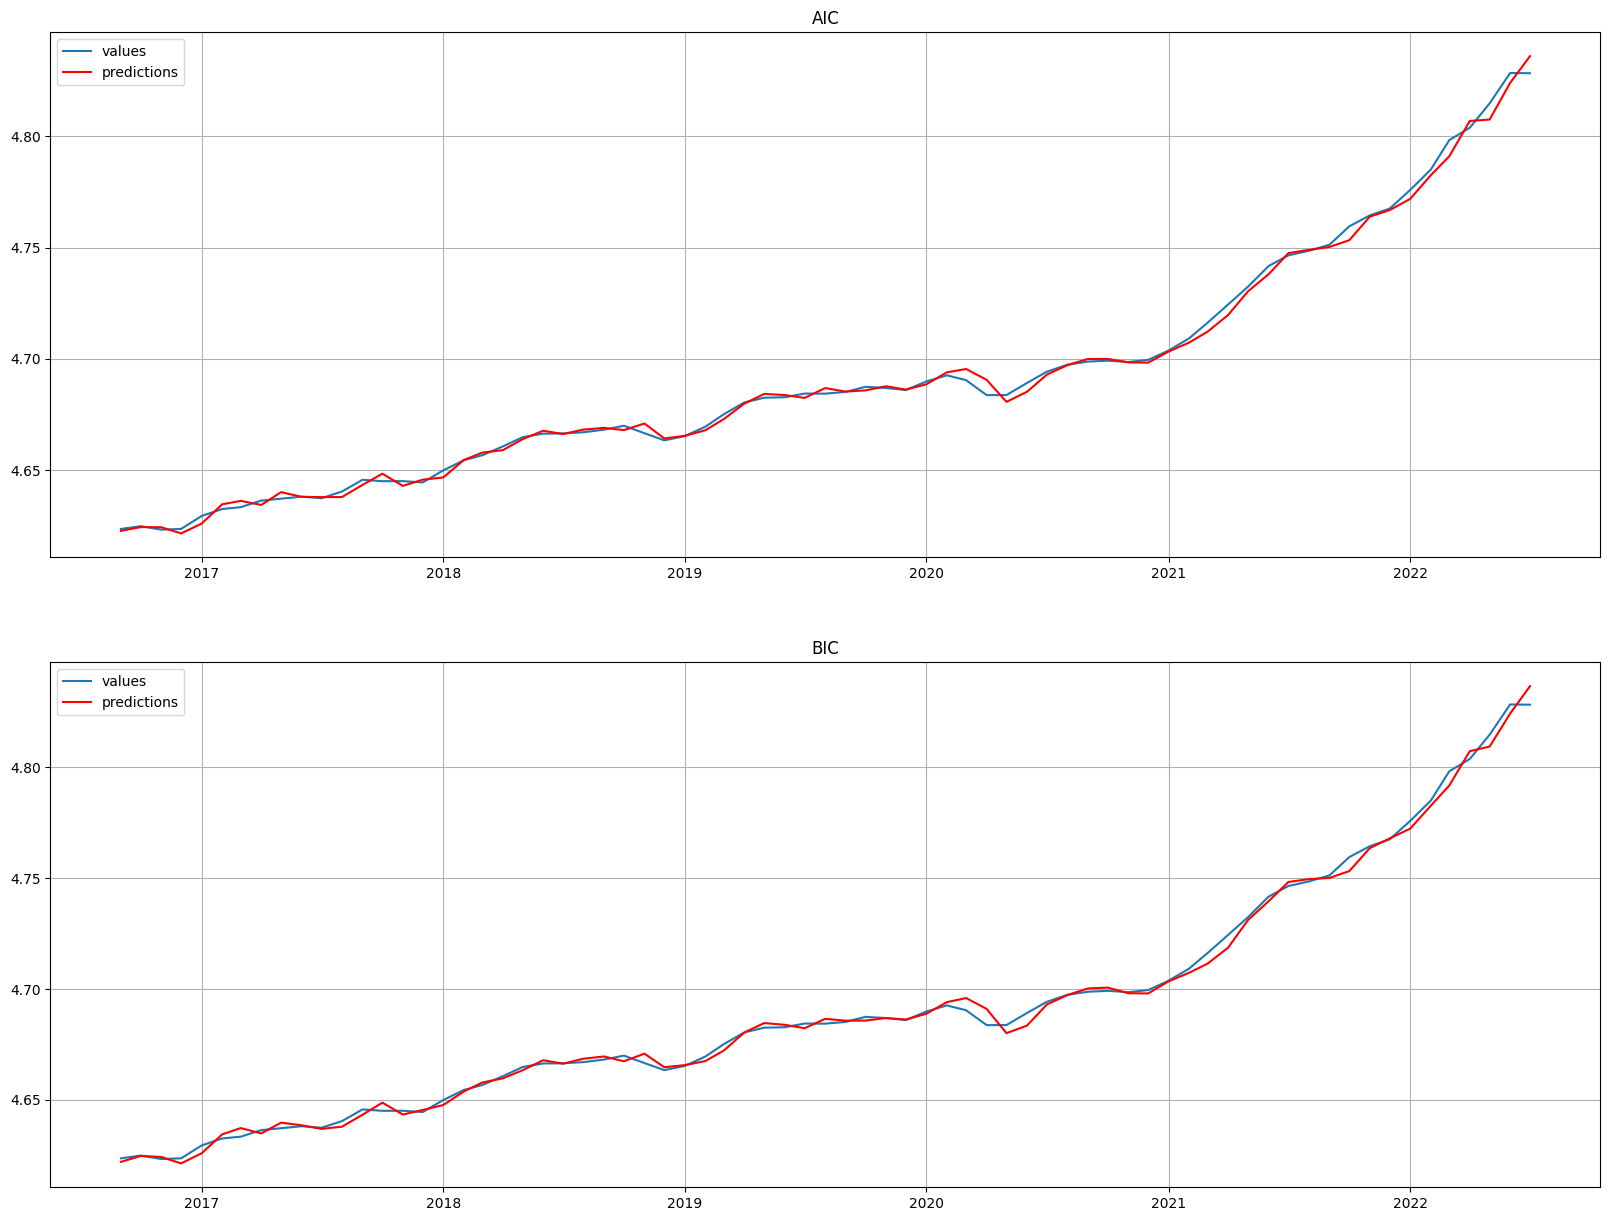

In [128]:
fig, ax = plt.subplots(2,1, figsize=(20,15))

ax[0].plot((data[80:]), label='values')
ax[0].plot((data[80:] - pd.DataFrame(resids_aic[80:], index=data.index[80:], columns=data.columns)), c='r', label='predictions')
ax[0].grid()
ax[0].legend()
ax[0].title.set_text("AIC")

ax[1].plot(data[80:], label='values')
ax[1].plot(data[80:] - pd.DataFrame(resids_bic[80:], index=data.index[80:], columns=data.columns), c='r', label='predictions')
ax[1].grid()
ax[1].legend()
ax[1].title.set_text("BIC")

plt.show()

That's the way to go. The predictions seem to be pretty close to the real values, however unfortunately the model doesn't seem to catch the most of momentums too well and it simply seems a little bit delayed. Both of the models are very similar, but I think that for actual forecasting I would choose the BIC-based model.

### Now let us make a quick summary:

1. I have fit 2 SARIMA models, one of them based on AIC and the other one on BIC,
2. The distributions of the residuals were normal,
3. The residuals have not shown serial autocorrelation,
4. The residuals have not shown strong dependence on time,
5. The residuals have shown conditional heteroskedasticity (possibly of GARCH type, but it needs further confirmation)

### Nevertheless:

1. The distribution of the differences did not prove normal by the histogram,
2. The time series did show seasonal behaviour,
3. The lagplots did show possible nonlinear relationship

and that leads me to believe that some kind of nonlinear, bivariate or multivariate model might show better fit. And this is precisely what I'm going to do in further analysis!